# Forecasting on a long horizon with TimeGPT

By definition, a "long horizon" is when predictions are made over a range that exceeds one or two seasonal periods. This is often the case when dealing with data sampled at a high frequency, such as daily or hourly.

For example, consider data sampled every hour with a daily frequency. This means that each seasonal cycle contains 24 time steps, so forecasting more than three days into the future is considered a long horizon.

Of course, forecasting over a long horizon comes with its challenges. The longer the forecast horizon, the greater the uncertainty in the predictions. It is also possible to have unknown factors come into play in the long-term that were not expected at the time of forecasting.

With TimeGPT, you can use a specialized model specifically built to handle long-horizon forecasting.

In [ ]:
#| hide
from nixtlats.utils import colab_badge

In [ ]:
#| hide
from dotenv import load_dotenv

In [ ]:
#| hide
load_dotenv()

True

In [ ]:
from nixtlats import TimeGPT

In [ ]:
timegpt = TimeGPT(
    # defaults to os.environ.get("TIMEGPT_TOKEN")
    token = 'my_token_provided_by_nixtla'
)

In [ ]:
#| hide
timegpt = TimeGPT()

Let's load the Etth1 dataset. This is a widely used dataset to evaluate models on their long-horizon forecasting capabalities. 

The ETTh1 dataset monitors an electricity transformer from a region of a province of China including oil temperature and variants of load (such as high useful load and high useless load) from July 2016 to July 2018 at an hourly frequency.

For this tutorial, let's only consider the oil temperature variation over time.

In [ ]:
from datasetsforecast.long_horizon import LongHorizon

Y_df, *_ = LongHorizon.load(directory='./', group='ETTh1')

Y_df.head()

100%|██████████| 314M/314M [00:37<00:00, 8.47MiB/s] 
INFO:datasetsforecast.utils:Successfully downloaded datasets.zip, 314116557, bytes.
INFO:datasetsforecast.utils:Decompressing zip file...
INFO:datasetsforecast.utils:Successfully decompressed longhorizon/datasets/datasets.zip


,unique_id,ds,y
0,OT,2016-07-01 00:00:00,1.460552
1,OT,2016-07-01 01:00:00,1.161527
2,OT,2016-07-01 02:00:00,1.161527
3,OT,2016-07-01 03:00:00,0.862611
4,OT,2016-07-01 04:00:00,0.525227


For this small experiment, let's set the horizon to 96 time steps (4 days into the future), and we will feed TimeGPT with a sequence that is twice the forecast horizon.

In [ ]:
test = Y_df[-96:]
input_seq = Y_df[-288:-96]

96 192


Now, we are ready to use TimeGPT for long-horizon forecasting. Here, we need to set the `model` parameter to `"timegpt-1-long-horizon"`. This is the specialized model in TimeGPT that can handle such tasks.

In [ ]:
fcst_df = timegpt.forecast(
    df=input_seq,
    h=96,
    model='timegpt-1-long-horizon',
    time_col='ds',
    target_col='y'
)

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: H
INFO:nixtlats.timegpt:Calling Forecast Endpoint...


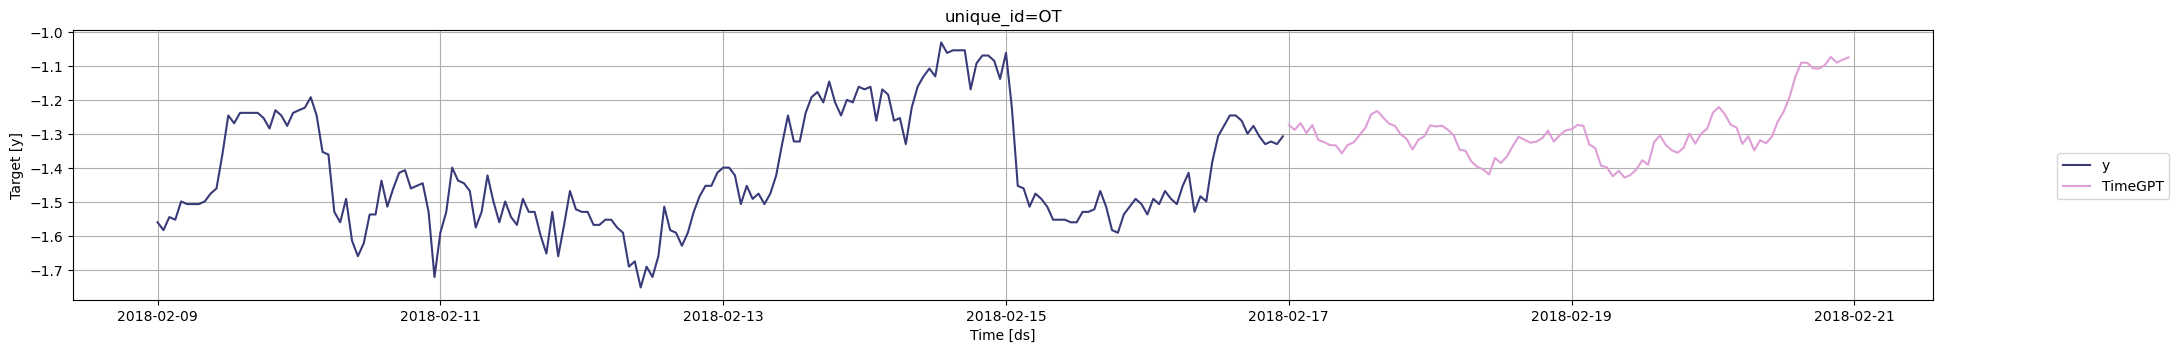

In [ ]:
timegpt.plot(input_seq, fcst_df, time_col='ds', target_col='y')

Let's now evaluate the performance of TimeGPT using the mean absolute error (MAE).

In [ ]:
test = test.copy()

test.loc[:, 'TimeGPT'] = fcst_df['TimeGPT'].values

In [ ]:
from utilsforecast.losses import mae

evaluation = mae(test, models=['TimeGPT'], id_col='unique_id', target_col='y')

print(evaluation)

  unique_id   TimeGPT
0        OT  0.282639


Here, TimeGPT achieves a MAE of 0.28.